In [1]:
import numpy as np
from numba import njit

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import os
os.environ[ 'NUMBA_CACHE_DIR' ] = '/tmp/numba_cache'

## N-Body problems

Many physical problems require the evaluation of all pairwise interactions of a large number of particles, so-called N-body problems. These problems arise in molecular dynamics, astrodynamics and electromagnetics among others. 

Their pairwise interactions can be expressed as:

\begin{equation}
f_i = \sum_{j=1}^n{P \left(\boldsymbol{x}_i, \boldsymbol{x}_j \right)w_j} \ \ \ \text{for } i=1,2,...,n 
\end{equation}

*  where subscripts $i$,  $j$ respectively denote *target* and *source*
*  $f_i$ can be a *potential* (or *force*) at target point $i$
*  $w_j$ is the *source weight* 
*  $\boldsymbol{x}_i, \boldsymbol{x}_j$ are the *spatial positions* of particles 
*  $P \left(\boldsymbol{x}_i, \boldsymbol{x}_j \right)$ is the *interaction kernel*. 

In order to evalute the potential $f_i$ at a target point $i$, we have to loop over each source particle $j$. Since there are $n$ target points $i$, this 'brute-force' approach costs $\mathcal{O} \left(n^2 \right)$ operations. 

One possible approach in this kind of problem is to define a few classes, say `Point` and `Particle` and then loop over the objects and perform the necessary point-to-point calculations.

In [3]:
class Point():
    """    
    Arguments:
        domain: the domain of random generated coordinates x,y,z, 
                default=1.0
    
    Attributes:
        x, y, z: coordinates of the point
    """
    def __init__(self, domain=1.0):
        self.x = domain * np.random.random()
        self.y = domain * np.random.random()
        self.z = domain * np.random.random()
            
    def distance(self, other):
        return ((self.x - other.x)**2 + 
                (self.y - other.y)**2 + 
                (self.z - other.z)**2)**.5

In [4]:
class Particle(Point):
    """    
    Attributes:
        m: mass of the particle
        phi: the potential of the particle
    """
    
    def __init__(self, domain=1.0, m=1.0):
        Point.__init__(self, domain)
        self.m = m
        self.phi = 0.

### Exercise 1

Write a function `create_n_random_particles` that takes the arguments `n` (number of particles), `m` (mass of every particle) and a domain within to generate a random number (as in the class above).
It should create an array with `n` elements and `dtype=particle_dtype` and then return that array.

For each particle, the mass should be initialized to the value of `m` and the potential `phi` initialized to zero.

For the `x` component of a given particle `p`, you might do something like

```python
p['x'] = domain * numpy.random.random()
```

In [5]:
particle_dtype = np.dtype({'names':['x','y','z','m','phi'], 
                             'formats':[np.double, 
                                        np.double, 
                                        np.double, 
                                        np.double, 
                                        np.double]})

In [6]:
@njit
def create_n_random_particles(n, m, domain=1.0):
    '''
    Creates `n` particles with mass `m` with random coordinates
    between 0 and `domain`
    '''
    parts = np.zeros((n), dtype=particle_dtype)
    for i in range(n):
        parts[i]['x'] = domain * np.random.random()
        parts[i]['y'] = domain * np.random.random()
        parts[i]['z'] = domain * np.random.random()
        parts[i]['m'] = m
        parts[i]['phi'] = 0.0
    return parts  #parts is an array of particles

In [7]:
n = 1000
m = 1 / n
parts = create_n_random_particles(n, m)
parts.shape, parts.dtype

((1000,),
 dtype([('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('m', '<f8'), ('phi', '<f8')]))

In [8]:
parts[0]

(0.86542868, 0.41501949, 0.55594457, 0.001, 0.)

In [9]:
%timeit create_n_random_particles(n = n, m = m, domain = 1.0)

10.6 µs ± 264 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [10]:
@njit
def distance(p1, p2):
    '''calculate the distance between two particles'''
    return ((p1.x - p2.x) ** 2 + 
            (p1.y - p2.y) ** 2 + 
            (p1.z - p2.z) ** 2) ** 0.5

In [11]:
%timeit distance(parts[100], parts[500])

1.1 µs ± 18 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [12]:
distance(parts[100], parts[500])

0.34507951684985877

In [13]:
def direct_sum(particles):
    """
    Calculate the potential at each particle
    using direct summation method.

    Arguments:
        particles: the list of particles

    """
    for i, target in enumerate(particles):
        for source in (particles[:i] + particles[i+1:]):
            r = target.distance(source)
            target.phi += source.m / r
    return particles

In [14]:
@njit
def direct_sum_jit(particles):
    for k in range(particles.shape[0]-1):
        for i in range(particles.shape[0]-1):
            if k == i:
                pass
            else:
                r = distance(particles[k], particles[i])
                particles[k].phi += particles[i].m / r
    return particles

In [15]:
n = 1000
particles = [Particle(m = 1 / n) for i in range(n)]
direct_sum(particles)[0].phi

1.7053089796660026

In [16]:
n = 1000
m = 1 / n
parts = create_n_random_particles(n, m)
direct_sum_jit(parts)[0]['phi']

1.7064456450953969

In [17]:
from tqdm import tqdm

times_vanilla = []
times_jit = []
sizes = np.arange(100, 2100, 100)

for n_parts in tqdm(sizes):
    n = n_parts
    m = 1 / n_parts

    parts = [Particle(m = 1 / n) for i in range(n)]
    t = %timeit -n 1 -o -q direct_sum(parts)
    times_vanilla.append(t)
    
    parts = create_n_random_particles(n = n, m = m, domain = 1.0)
    t = %timeit -n 1 -o -q direct_sum_jit(parts)
    times_jit.append(t)


100%|███████████████████████████████████████████| 20/20 [01:50<00:00,  5.52s/it]


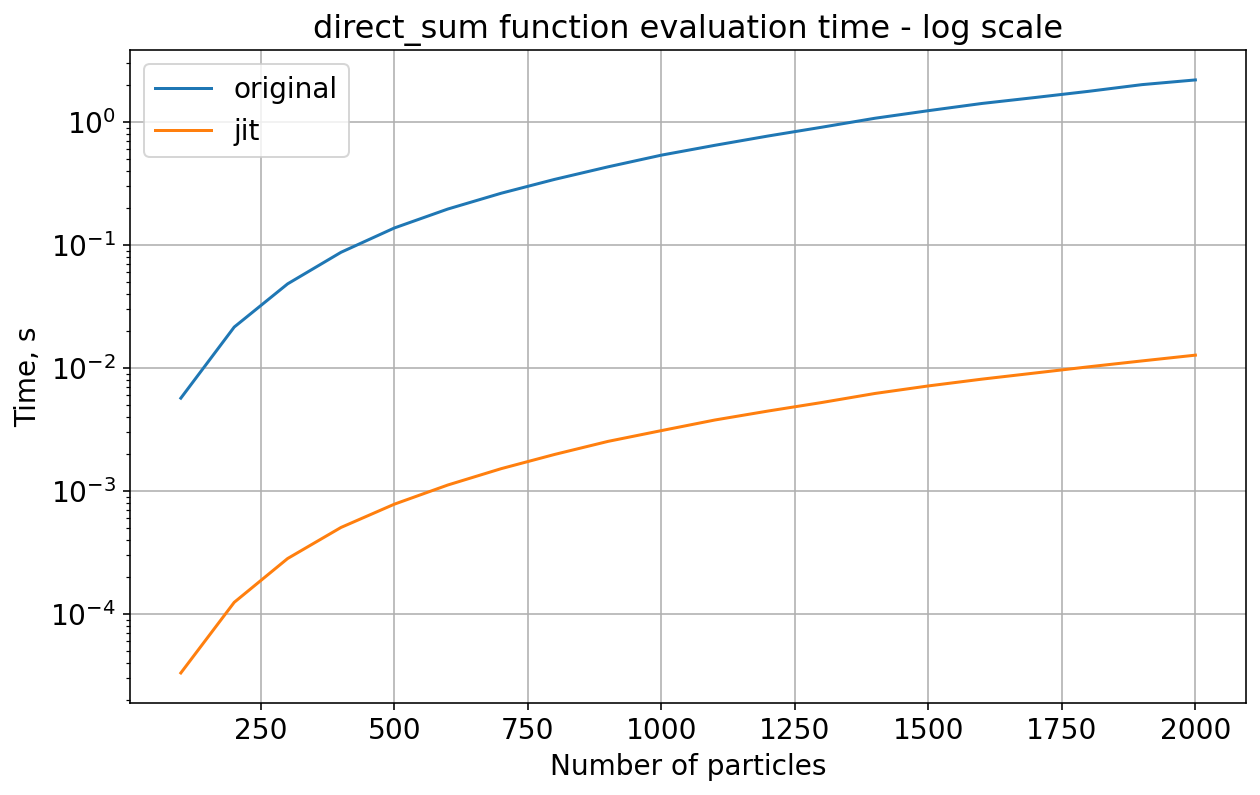

In [20]:
plt.figure(figsize=(10,6))
plt.plot(sizes, [i.average for i in times_vanilla])
plt.plot(sizes, [i.average for i in times_jit])
plt.title('direct_sum function evaluation time - log scale', fontsize=16)
plt.xlabel('Number of particles', fontsize=14)
plt.ylabel('Time, s', fontsize=14)
plt.yscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['original', 'jit'], fontsize=14);
plt.grid()
plt.show()

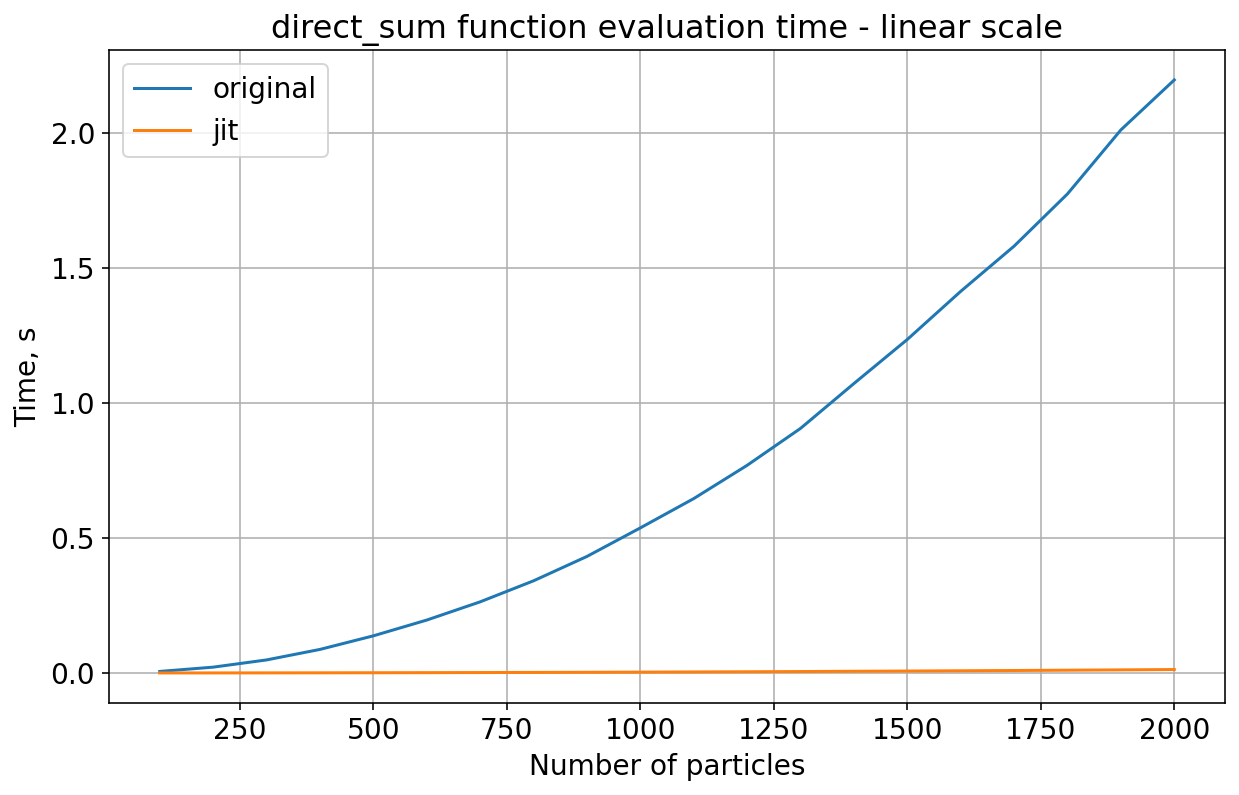

In [19]:
plt.figure(figsize=(10,6))
plt.plot(sizes, [i.average for i in times_vanilla])
plt.plot(sizes, [i.average for i in times_jit])
plt.title('direct_sum function evaluation time - linear scale', fontsize=16)
plt.xlabel('Number of particles', fontsize=14)
plt.ylabel('Time, s', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['original', 'jit'], fontsize=14);
plt.grid()
plt.show()